# **Re**lative **Lo**ss **B**alancing with **Ra**ndom **Lo**okbacks for Helmholtz PDE
This notebook implements the concepts from the [Multi-Objective Loss Balancing for Physics-Informed Deep Learning paper](https://arxiv.org/abs/2110.09813) and [Improving PINNs through Adaptive Loss Balancing medium article](https://medium.com/p/55662759e701). It showcases the gains in performance when applying Loss Balancing Schemes to PINN training.



In [ ]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from typing import Tuple, Callable, List, Union
from tensorflow.experimental.numpy import isclose
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Utility functions
We start by defining a few utility functions that will be useful later. The first, *compute_derivatives*, computes all the derivatives necessary to formulate the Helmholtz PINN objective (it is a second order differential equation).



In [ ]:
def compute_derivatives(x, y, u):
    """
    Computes the derivatives of `u` with respect to `x` and `y`.

    Parameters
    ----------
    x : tf.Tensor
        The x-coordinate of the collocation points, of shape (batch_size, 1).
    y : tf.Tensor
        The y-coordinate of the collocation points, of shape (batch_size, 1).
    u : tf.Tensor
        The prediction made by the PINN, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The second order derivatives of `u` with respect to `x`, `y`.
    """
    dudx, dudy = tf.gradients(u, [x, y])
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    return dudxx, dudyy

## Define Helmholtz PDE Class (cas (a) avec une source en produit de sinus -> résoluble)

The Helmholtz equation is a partial differential equation that describes the propagation of waves in a medium. It is a second-order equation and named after the German physicist Hermann von Helmholtz. We can define the problem such that there exists an analytical solution, against which we can compare our PINN:

$$
    f(x, y) = (-\pi^2 - (4\pi)^2 + k^2) sin(\pi x) sin(4 \pi y) \\
    u(x, y) = sin(\pi x) sin(4 \pi y)\\
    u(-1, y) = u(1, y) = u(x, -1) = u(x, 1) = 0\\
$$
We consider the case where k = 1.

This class represents the [Helmholtz PDE](https://en.wikipedia.org/wiki/Helmholtz_equation). It provides a set of utility functions to train a [Physics Informed Neural Network (PINN)](https://arxiv.org/pdf/1711.10566.pdf) on the Helmholtz PDE. The class has functions that generate training and validation data, calculate loss, and visualize the results of the PINN's predictions.

In [ ]:
EPS = 1e-7

class HelmholtzPDE:
    """
    Class representing a Helmholtz pde, providing several methods for training a Physics-Informed Neural Network.
    """
    def __init__(self, u_val: Callable[[tf.Tensor, tf.Tensor], tf.Tensor]):
        """
        Initialize the HelmholtzPDE class.

        PARAMETERS
        ----------------
        u_val : Callable[[tf.Tensor, tf.Tensor], tf.Tensor]
            A function to validate the predictions.
        """
        self.u_val = u_val
        self.k = 2
        self.num_terms = 2

    def training_batch(self, batch_size_domain:int=4000, batch_size_boundary:int=100) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Generates a batch of collocation points by randomly sampling `batch_size_domain` points inside the domain
        and `batch_size_boundary` points on each of the four boundaries.

        PARAMETERS
        --------------------
        batch_size_domain : int
            number of points to be sampled inside of the domain
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries
        """
        x_in =  tf.random.uniform(shape=(batch_size_domain, 1), minval=-1, maxval=1)
        x_b1 = -tf.ones(shape=(batch_size_boundary, 1))
        x_b2 =  tf.ones(shape=(batch_size_boundary, 1))
        x_b3 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        x_b4 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        x = tf.concat([x_in, x_b1, x_b2, x_b3, x_b4], axis=0)

        y_in =  tf.random.uniform(shape=(batch_size_domain, 1), minval=-1, maxval=1)
        y_b1 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        y_b2 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        y_b3 = -tf.ones(shape=(batch_size_boundary, 1))
        y_b4 =  tf.ones(shape=(batch_size_boundary, 1))
        y = tf.concat([y_in, y_b1, y_b2, y_b3, y_b4], axis=0)

        return x, y

    def get_train_dataset(self, batch_size_domain:int=4000, batch_size_boundary:int=100):
        """
        Creates a tf.data.Dataset generator for training.

        Parameters
        ----------
        batch_size_domain : int
            number of points to be sampled inside of the domain. Default is 800.
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries. Default is 100.

        Returns
        -------
        tf.data.Dataset
            A `tf.data.Dataset` generator for training.
        """
        def generator():
            while True:
                xy = tf.concat(self.training_batch(batch_size_domain, batch_size_boundary), axis=-1)
                yield xy, xy

        return tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=((None, 2), (None, 2))
        )

    def validation_batch(self, grid_width:int=64, grid_height:int=64):
        """
        Generates a grid of points that can easily be used to generate an image of the pde,
        where each point is a pixel.

        PARAMETERS
        ----------
        grid_width : int
            width of the grid
        grid_height : int
            height of the grid
        """
        x, y = np.mgrid[-1:1:complex(0, grid_width), -1:1:complex(0, grid_height)]
        x = tf.cast(x.reshape(grid_width * grid_height, 1), dtype=tf.float32)
        y = tf.cast(y.reshape(grid_width * grid_height, 1), dtype=tf.float32)
        u = tf.math.sin(np.pi * x) * tf.math.sin(4 * np.pi * y)
        return x, y, u

    def compute_loss(self, x, y, preds, eval=False):
        """
        Computes the physics-informed loss for Helmholtz's PDE.

        Parameters
        ----------
        x : tf.Tensor of shape (batch_size, 1)
            x coordinate of the points in the current batch
        y : tf.Tensor of shape (batch_size, 1)
            y coordinate of the points in the current batch
        preds : tf.Tensor of shape (batch_size, 6)
            predictions made by our PINN (dim 0) as well as dudxx (dim 1), dudyy (dim 2)
        """

        # governing equation loss
        L_f = (preds[:, 1:2] + preds[:, 2:3] + self.k**2 * preds[:, 0:1] - \
              (-np.pi**2 - (4 * np.pi)**2 + self.k**2) * tf.math.sin(np.pi * x) * tf.math.sin(4 * np.pi * y))**2

        # determine which points are on the boundaries of the domain
        # if a point is on either of the boundaries, its value is 1 and 0 otherwise
        x_lower = tf.cast(isclose(x, -1, rtol=0., atol=EPS), dtype=tf.float32)
        x_upper = tf.cast(isclose(x,  1, rtol=0., atol=EPS), dtype=tf.float32)
        y_lower = tf.cast(isclose(y, -1, rtol=0., atol=EPS), dtype=tf.float32)
        y_upper = tf.cast(isclose(y,  1, rtol=0., atol=EPS), dtype=tf.float32)

        # compute 0th order boundary condition loss
        L_b = ((x_lower + x_upper + y_lower + y_upper) * preds[:, 0:1])**2

        if eval:
            L_u = (tf.math.sin(np.pi*x) * tf.math.sin(4*np.pi*y) - preds[:, 0:1])**2
            return L_f, L_b, L_u

        return L_f, L_b

    @tf.function
    def __validation_results(self, pinn: tf.keras.Model, image_width: int = 64, image_height: int = 64):
        """Computes the validation results for the given model.

        Parameters
        ----------
        pinn : tf.keras.Model
            A TensorFlow Keras model instance.
        image_width : int
            The width of the image (defaults to 64).
        image_height : int
            The height of the image (defaults to 64).

        Returns:
        u_real : tf.Tensor
            A tensor containing the real displacement.
        u_pred : tf.Tensor
            A tensor containing the predicted displacement.
        f : tf.Tensor
            A tensor containing the governing equation.
        """
        x, y, u_real = self.validation_batch(image_width, image_height)
        pred = pinn(tf.concat([x, y], axis=-1), training=False)
        u_pred, dudxx, dudyy = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]
        sin_xy = tf.math.sin(np.pi*x) * tf.math.sin(4*np.pi*y)
        f = (dudxx + dudyy + self.k * u_pred - (-np.pi**2 - (4*np.pi)**2 + self.k**2) * sin_xy)**2
        return u_real, u_pred, f


    def visualise(self, pinn: tf.keras.Model = None, image_width: int = 64, image_height: int = 64):
        """
        If no model is provided, visualises only the load distribution on the plate.
        Otherwise, visualizes the results of the given model.

        Parameters
        ----------
        pinn : tf.keras.Model
            A TensorFlow Keras model instance.
        image_width : int
            The width of the image (defaults to 64).
        image_height : int
            The height of the image (defaults to 64).
        """
        if pinn is None:
            x, y, u_real = self.validation_batch(image_width, image_height)
            self.__show_image(u_real.numpy().reshape(image_width, image_height))
            plt.show()

        else:
            u_real, u_pred, f = self.__validation_results(pinn, image_width, image_height)
            u_real = u_real.numpy().reshape(image_width, image_height)
            u_pred = u_pred.numpy().reshape(image_width, image_height)
            f = f.numpy().reshape(image_width, image_height)

            fig, axs = plt.subplots(2, 2, figsize=(8, 7))
            self.__show_image(u_pred, axs[0, 0], 'Predicted')
            self.__show_image((u_pred - u_real)**2, axs[0, 1], 'Squared Error')
            self.__show_image(f, axs[1, 0], 'Governing Equation')
            self.__show_image(f**2, axs[1, 1], 'Squared Error Governing Equation')

            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()
            plt.tight_layout()
            plt.show()

    def __show_image(self, img:np.array, axis:plt.axis=None, title:str='', x_label='x', y_label='y', z_label=''):
        if axis is None:
             _, axis = plt.subplots(1, 1, figsize=(4, 3.2), dpi=100)
        im = axis.imshow(np.rot90(img, k=3), cmap='plasma', origin='lower', aspect='auto')
        cb = plt.colorbar(im, label=z_label, ax=axis)
        axis.set_xticks([0, img.shape[0]-1])
        axis.set_xticklabels([-1, 1])
        axis.set_yticks([0, img.shape[1]-1])
        axis.set_yticklabels([-1, 1])
        axis.set_xlabel(x_label)
        axis.set_ylabel(y_label)
        axis.set_title(title)
        return im

## Helmholtz PINN Loss Function

### Default Helmholtz PDE Loss
This class inherits from the keras Loss class and can be used in the keras API (i.e. model.fit()) for training our Helmholtz PINN.

In [ ]:
class HelmholtzLoss(tf.keras.losses.Loss):
    """
    Helmholtz Loss for physics-informed neural network.

    Parameters
    ----------
    pde: HelmholtzPDE
        The HelmholtzPDE object representing the PDE
        The name of the loss, by default 'ReLoBRaLoHelmholtzLoss'
    """
    def __init__(self, pde:HelmholtzPDE, name='HelmholtzLoss'):
        super().__init__(name=name)
        self.pde = pde

    def call(self, xy, preds):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_b = self.pde.compute_loss(x, y, preds)
        loss = L_f + L_b
        return tf.reduce_mean(loss)

### ReLoBRaLo Loss Balancing Objective
This class inherits from the HelmholtzLoss class and balances the contributions towards the total loss by scaling the terms L_0, L_b0 and L_b2 according to the ReLoBRaLo loss balancing scheme.

$$
\lambda_i^{\textit{bal}}(t, t') = k\cdot\frac{\operatorname{exp}\left(\frac{L_i(t)}{\tau L_i(t')}\right)}{\sum_{j=1}^k \operatorname{exp} \left(\frac{L_j(t)}{\tau L_j(t')} \right)}, \; i \in \{1, \dots, k\}\\
\lambda_{i}^{\textit{hist}}(t) = \rho\lambda_i(t-1) + (1-\rho)\lambda_i^{\textit{bal}}(t, 0))\\
\lambda_i(t) = \alpha\lambda_{i}^{\textit{hist}} + (1-\alpha)\lambda_i^{\textit{bal}}(t, t-1)\\
$$

where $\alpha$ is the exponential decay rate, $\rho$ is a Bernoulli random variable and $\mathbb{E}[\rho]$ should be chosen close to 1. The intermediate step $\lambda_i^{\textit{bal}}(t, t')$ calculates scalings based on the relative improvements of each term between time steps $t'$ and $t$. The following step $\lambda_{i}^{\textit{hist}}(t)$ defines, whether the scalings calculated in the previous time step ($\rho$ evaluates to 1) or the relative improvements since the beginning of training ($\rho$ evaluates to 0) should be carried forward. Note that this concept of randomly retaining or discarding the history of scalings is what we denote as "random lookbacks". Finally, the scaling $\lambda_i(t)$ for term $i$ is obtained by means of an exponential decay, where $\alpha$ controls the weight given to past scalings versus the scalings calculated in the current time step.

In [ ]:
class ReLoBRaLoHelmholtzLoss(HelmholtzLoss):
    """
    Class for the ReLoBRaLo Helmholtz Loss.
    This class extends the Helmholtz Loss to have dynamic weighting for each term in the calculation of the loss.
    """
    def __init__(self, pde:HelmholtzPDE, alpha:float=0.999, temperature:float=1., rho:float=0.9999,
                 name='ReLoBRaLoHelmholtzLoss'):
        """
        Parameters
        ----------
        pde : HelmholtzPDE
            An instance of HelmholtzPDE class containing the `compute_loss` function.
        alpha, optional : float
            Controls the exponential weight decay rate.
            Value between 0 and 1. The smaller, the more stochasticity.
            0 means no historical information is transmitted to the next iteration.
            1 means only first calculation is retained. Defaults to 0.999.
        temperature, optional : float
            Softmax temperature coefficient. Controlls the "sharpness" of the softmax operation.
            Defaults to 1.
        rho, optional : float
            Probability of the Bernoulli random variable controlling the frequency of random lookbacks.
            Value berween 0 and 1. The smaller, the fewer lookbacks happen.
            0 means lambdas are always calculated w.r.t. the initial loss values.
            1 means lambdas are always calculated w.r.t. the loss values in the previous training iteration.
            Defaults to 0.9999.
        """
        super().__init__(pde, name=name)
        self.pde = pde
        self.alpha = alpha
        self.temperature = temperature
        self.rho = rho
        self.call_count = tf.Variable(0, trainable=False, dtype=tf.int16)

        self.lambdas = [tf.Variable(1., trainable=False) for _ in range(pde.num_terms)]
        self.last_losses = [tf.Variable(1., trainable=False) for _ in range(pde.num_terms)]
        self.init_losses = [tf.Variable(1., trainable=False) for _ in range(pde.num_terms)]

    def call(self, xy, preds):
        x, y = xy[:, :1], xy[:, 1:]
        losses = [tf.reduce_mean(loss) for loss in self.pde.compute_loss(x, y, preds)]

        # in first iteration (self.call_count == 0), drop lambda_hat and use init lambdas, i.e. lambda = 1
        #   i.e. alpha = 1 and rho = 1
        # in second iteration (self.call_count == 1), drop init lambdas and use only lambda_hat
        #   i.e. alpha = 0 and rho = 1
        # afterwards, default procedure (see paper)
        #   i.e. alpha = self.alpha and rho = Bernoully random variable with p = self.rho
        alpha = tf.cond(tf.equal(self.call_count, 0),
                lambda: 1.,
                lambda: tf.cond(tf.equal(self.call_count, 1),
                                lambda: 0.,
                                lambda: self.alpha))
        rho = tf.cond(tf.equal(self.call_count, 0),
              lambda: 1.,
              lambda: tf.cond(tf.equal(self.call_count, 1),
                              lambda: 1.,
                              lambda: tf.cast(tf.random.uniform(shape=()) < self.rho, dtype=tf.float32)))

        # compute new lambdas w.r.t. the losses in the previous iteration
        lambdas_hat = [losses[i] / (self.last_losses[i] * self.temperature + EPS) for i in range(len(losses))]
        lambdas_hat = tf.nn.softmax(lambdas_hat - tf.reduce_max(lambdas_hat)) * tf.cast(len(losses), dtype=tf.float32)

        # compute new lambdas w.r.t. the losses in the first iteration
        init_lambdas_hat = [losses[i] / (self.init_losses[i] * self.temperature + EPS) for i in range(len(losses))]
        init_lambdas_hat = tf.nn.softmax(init_lambdas_hat - tf.reduce_max(init_lambdas_hat)) * tf.cast(len(losses), dtype=tf.float32)

        # use rho for deciding, whether a random lookback should be performed
        new_lambdas = [(rho * alpha * self.lambdas[i] + (1 - rho) * alpha * init_lambdas_hat[i] + (1 - alpha) * lambdas_hat[i]) for i in range(len(losses))]
        self.lambdas = [var.assign(tf.stop_gradient(lam)) for var, lam in zip(self.lambdas, new_lambdas)]

        # compute weighted loss
        loss = tf.reduce_sum([lam * loss for lam, loss in zip(self.lambdas, losses)])

        # store current losses in self.last_losses to be accessed in the next iteration
        self.last_losses = [var.assign(tf.stop_gradient(loss)) for var, loss in zip(self.last_losses, losses)]
        # in first iteration, store losses in self.init_losses to be accessed in next iterations
        first_iteration = tf.cast(self.call_count < 1, dtype=tf.float32)
        self.init_losses = [var.assign(tf.stop_gradient(loss * first_iteration + var * (1 - first_iteration))) for var, loss in zip(self.init_losses, losses)]

        self.call_count.assign_add(1)

        return loss

## Metrics for logging

### Custom Metric for logging Helmholtz Loss Terms

In [ ]:
class HelmholtzMetric(tf.keras.metrics.Metric):
    """
    Helmholtz metric to log the values of each loss term, i.e. L_f and L_b.
    """
    def __init__(self, pde: HelmholtzPDE, name='Helmholtz_metric', **kwargs):
        """Initialize Helmholtz metric with a HelmholtzPDE instance and metric name.

        Parameters
        ----------
        pde : HelmholtzPDE
            Instance of the HelmholtzPDE.
        name : str, optional
            Name of the metric. Defaults to 'Helmholtz_metric'.
        """
        super().__init__(name=name, **kwargs)
        self.pde = pde
        self.L_f_mean = self.add_weight(name='L_f_mean', initializer='zeros')
        self.L_b_mean = self.add_weight(name='L_b_mean', initializer='zeros')
        self.L_u_mean = self.add_weight(name='L_u_mean', initializer='zeros')

    def update_state(self, xy, y_pred, sample_weight=None):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_b, L_u = self.pde.compute_loss(x, y, y_pred, eval=True)
        self.L_f_mean.assign(tf.reduce_mean(L_f[:, 0], axis=0))
        self.L_b_mean.assign(tf.reduce_mean(L_b[:, 0], axis=0))
        self.L_u_mean.assign(tf.reduce_mean(L_u[:, 0], axis=0))

    def reset_state(self):
        self.L_f_mean.assign(0)
        self.L_b_mean.assign(0)
        self.L_u_mean.assign(0)

    def result(self):
        return {'L_f': self.L_f_mean, 'L_b': self.L_b_mean, 'L_u': self.L_u_mean}

### Custom Metric for logging ReLoBRaLo weights

In [ ]:
class ReLoBRaLoLambdaMetric(tf.keras.metrics.Metric):
    """
    A custom TensorFlow metric class to monitor the lambdas of the ReLoBRaLoHelmholtzLoss.
    """
    def __init__(self, loss:ReLoBRaLoHelmholtzLoss, name='relobralo_lambda_metric', **kwargs):
        """
        Parameters
        ----------
        loss : ReLoBRaLoHelmholtzLoss)
            The ReLoBRaLoHelmholtzLoss object that holds the lambdas.
        name : str, optional)
            The name of the metric. Defaults to 'relobralo_lambda_metric'.
        """
        super().__init__(name=name, **kwargs)
        self.loss = loss
        self.L_f_lambda_mean = self.add_weight(name='L_f_lambda_mean', initializer='zeros')
        self.L_b_lambda_mean = self.add_weight(name='L_b_lambda_mean', initializer='zeros')

    def update_state(self, xy, y_pred, sample_weight=None):
        L_f_lambda, L_b_lambda = self.loss.lambdas
        self.L_f_lambda_mean.assign(L_f_lambda)
        self.L_b_lambda_mean.assign(L_b_lambda)

    def reset_state(self):
        self.L_f_lambda_mean.assign(0)
        self.L_b_lambda_mean.assign(0)

    def result(self):
        return {'L_f_lambda': self.L_f_lambda_mean, 'L_b_lambda': self.L_b_lambda_mean}

## PINN Model

In [ ]:
class HelmholtzPINN(tf.keras.Model):
    """
    This class is a implementation of a physics-informed neural network (PINN)
    for the Helmholtz partial differential equation (PDE).
    """
    def __init__(self, layer_widths: List[int]=[64, 64, 64], activation: Union[str, Callable]='tanh', **kwargs):
        """
        Parameters
        ----------
        layer_widths : List[int], optional
            List of integers representing the widths of the hidden layers in the model.
        activation : Union[str, Callable], optional
            Activation function to be applied in each layer.
        """
        super().__init__(**kwargs)
        self.layer_sequence = [tf.keras.layers.Dense(width, activation=activation, kernel_initializer='glorot_normal') for width in layer_widths]
        self.layer_sequence.append(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal'))

    def call(self, xy, training=None, mask=None):
        x, y = xy[:, :1], xy[:, 1:]

        u = Concatenate()([x, y])
        for layer in self.layer_sequence:
            u = layer(u)

        dudxx, dudyy = compute_derivatives(x, y, u)

        return tf.concat([u, dudxx, dudyy], axis=-1)

## Problem definition
Define the problem such that there exists an analytical solution, against which we can compare our PINN:

$$
    u(x, y) = sin(\pi x) sin(4 \pi y)\\
$$

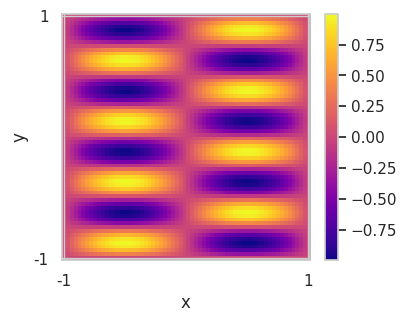

In [ ]:
u_val = lambda x, y: tf.math.sin(x * np.pi) * tf.math.sin(4 * y * np.pi)
pde = HelmholtzPDE(u_val=u_val)
pde.visualise()

### Train without loss balancing
Now that the PDE has been defined, we can build the model as well as the loss function. We are first using the default HelmholtzLoss and will compare it to the ReLoBRaLoHelmholtzLoss later.

In [ ]:
pinn = HelmholtzPINN()
loss = HelmholtzLoss(pde)
pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=[HelmholtzMetric(pde)])

In [ ]:
h = pinn.fit(
    pde.get_train_dataset(),
    epochs=800,  #was 1000
    steps_per_epoch=100,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, min_delta=0, verbose=True),
        EarlyStopping(monitor='loss', patience=32, restore_best_weights=True, verbose=True)
    ]
)

Epoch 1/800
100/100 [==============================] - 6s 9ms/step - loss: 6082.7002 - L_f: 6084.0414 - L_b: 0.0040 - L_u: 0.2550 - lr: 0.0010
Epoch 2/800
100/100 [==============================] - 1s 8ms/step - loss: 6069.6392 - L_f: 6066.2771 - L_b: 0.0320 - L_u: 0.4552 - lr: 0.0010
Epoch 3/800
100/100 [==============================] - 1s 8ms/step - loss: 3033.1799 - L_f: 3012.1700 - L_b: 0.2609 - L_u: 2.0867 - lr: 0.0010
Epoch 4/800
100/100 [==============================] - 1s 8ms/step - loss: 584.9626 - L_f: 583.2687 - L_b: 0.3720 - L_u: 3.2308 - lr: 0.0010
Epoch 5/800
100/100 [==============================] - 1s 8ms/step - loss: 410.1135 - L_f: 409.2780 - L_b: 0.5466 - L_u: 4.8318 - lr: 0.0010
Epoch 6/800
100/100 [==============================] - 1s 8ms/step - loss: 345.2256 - L_f: 344.5576 - L_b: 0.5736 - L_u: 5.3597 - lr: 0.0010
Epoch 7/800
100/100 [==============================] - 1s 8ms/step - loss: 302.0957 - L_f: 301.2839 - L_b: 0.5857 - L_u: 5.7415 - lr: 0.0010
Epoch 8

Visualise the progress of the several loss terms as well as the error against the analytical solution.

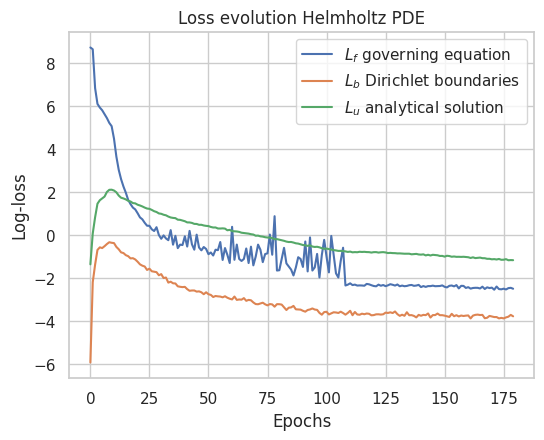

In [ ]:
fig = plt.figure(figsize=(6, 4.5), dpi=100)
plt.plot(np.log(h.history['L_f'])[:180], label='$L_f$ governing equation')
plt.plot(np.log(h.history['L_b'])[:180], label='$L_{b}$ Dirichlet boundaries')
plt.plot(np.log(h.history['L_u'])[:180], label='$L_u$ analytical solution')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-loss')
plt.title('Loss evolution Helmholtz PDE')
plt.show()

Visually inspect the error distribution on the physical domain.

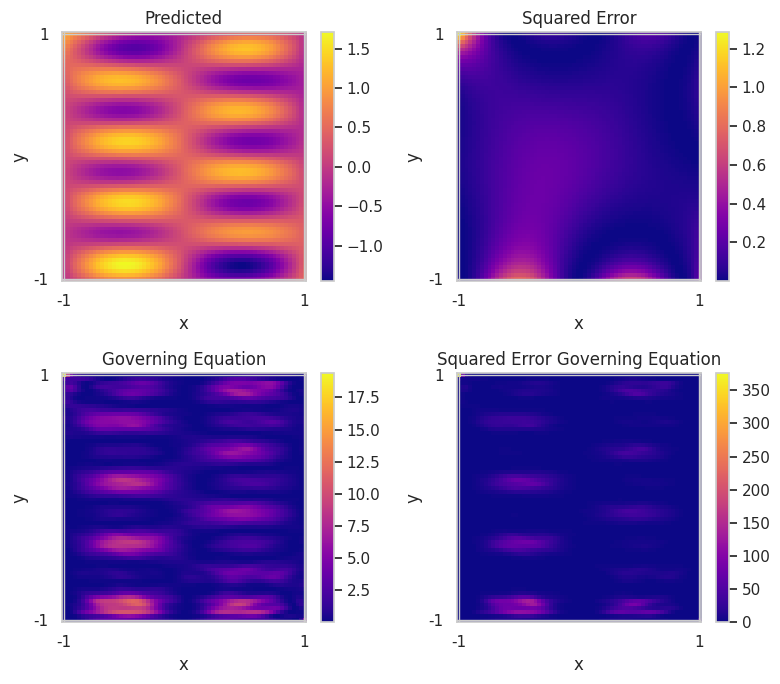

In [ ]:
pde.visualise(pinn)

### Train with ReLoBRaLo

In [ ]:
helmholtz_pinn = HelmholtzPINN()
relobralo_loss = ReLoBRaLoHelmholtzLoss(pde, temperature=0.01, rho=0.99, alpha=0.999)
helmholtz_pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=relobralo_loss, metrics=[HelmholtzMetric(pde), ReLoBRaLoLambdaMetric(relobralo_loss)])

In [ ]:
h_relobralo = helmholtz_pinn.fit(
    pde.get_train_dataset(),
    epochs=1000,
    steps_per_epoch=100,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, min_delta=0, verbose=True),
        EarlyStopping(monitor='loss', patience=32, restore_best_weights=True, verbose=True)
    ]
)

Epoch 1/1000
100/100 [==============================] - 5s 10ms/step - loss: 233.5452 - L_f: 4660.6085 - L_b: 0.0036 - L_u: 0.1763 - L_f_lambda: 0.0504 - L_b_lambda: 1.9496 - lr: 0.0010
Epoch 2/1000
100/100 [==============================] - 1s 10ms/step - loss: 436.9731 - L_f: 4556.4019 - L_b: 0.2742 - L_u: 0.7278 - L_f_lambda: 0.0962 - L_b_lambda: 1.9038 - lr: 0.0010
Epoch 3/1000
100/100 [==============================] - 1s 9ms/step - loss: 760.3350 - L_f: 4541.2190 - L_b: 0.6621 - L_u: 1.3859 - L_f_lambda: 0.1676 - L_b_lambda: 1.8324 - lr: 0.0010
Epoch 4/1000
100/100 [==============================] - 1s 9ms/step - loss: 427.2247 - L_f: 4029.0607 - L_b: 0.4903 - L_u: 0.9765 - L_f_lambda: 0.1014 - L_b_lambda: 1.8986 - lr: 0.0010
Epoch 5/1000
100/100 [==============================] - 1s 10ms/step - loss: 253.5404 - L_f: 2534.2516 - L_b: 0.6494 - L_u: 1.3390 - L_f_lambda: 0.1053 - L_b_lambda: 1.8947 - lr: 0.0010
Epoch 6/1000
100/100 [==============================] - 1s 11ms/step - l

Visualise the progress of the several loss terms as well as the error against the analytical solution.

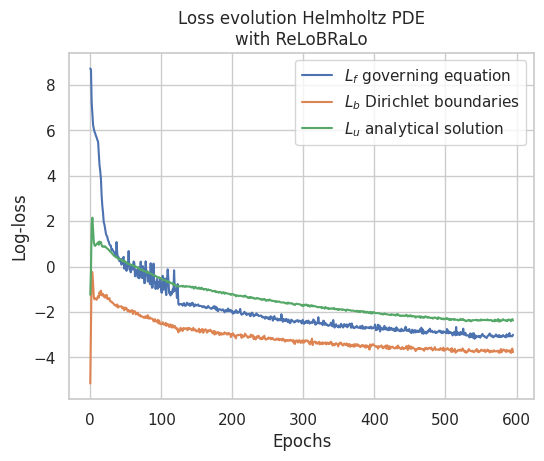

In [ ]:
fig = plt.figure(figsize=(6, 4.5), dpi=100)
plt.plot(np.log(h.history['L_f']), label='$L_f$ governing equation')
plt.plot(np.log(h.history['L_b']), label='$L_{b}$ Dirichlet boundaries')
plt.plot(np.log(h.history['L_u']), label='$L_u$ analytical solution')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-loss')
plt.title('Loss evolution Helmholtz PDE\nwith ReLoBRaLo')
plt.show()

Visualise the progress of the scalings $\lambda$.

In [ ]:
fig = plt.figure(figsize=(6, 4.5), dpi=100)
plt.plot(h_relobralo.history['L_f_lambda'], label='$\lambda_f$ governing equation')
plt.plot(np.array(h_relobralo.history['L_b_lambda']), label='$\lambda_{b}$ boundary condition')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('scalings $\lambda_i$')
plt.title('ReLoBRaLo weights on Helmholtz PDE')
plt.show()

NameError: name 'h_relobralo' is not defined

<Figure size 600x450 with 0 Axes>

Visually inspect the error distribution on the physical domain.

In [ ]:
pde.visualise(helmholtz_pinn)

NameError: name 'helmholtz_pinn' is not defined